In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn import naive_bayes

#from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB


from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import string
from textblob import TextBlob,Word
import nltk


from nltk.tokenize import word_tokenize
from nltk.corpus import words,wordnet
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [58]:
d1 = pd.read_csv("files/tweet_filtered_strict_ind_bad.csv")
d2 = pd.read_csv("files/tweet_filtered_strict_full.csv")
data = pd.concat([d1,d2])

In [59]:
data.shape

(96318, 4)

In [60]:
data.isnull().sum()

Unnamed: 0        0
tweet           996
polarity          0
subjectivity      0
dtype: int64

In [61]:
data.dropna(inplace=True)
data.shape

(95322, 4)

 Filter sentences if it has minimum of 5 words
 
 
 

In [62]:
data["filtered_sentence"]=data.tweet.apply(lambda x: x if(len(x.split())>2) else None)

In [63]:
data.isnull().sum()

Unnamed: 0              0
tweet                   0
polarity                0
subjectivity            0
filtered_sentence    4529
dtype: int64

In [64]:
data.dropna(inplace=True)
data.shape

(90793, 5)

In [124]:
tweets=data.copy()

In [125]:
sent = lambda x: 1 if(x>=0) else 0
tweets["sentiment"]=tweets.polarity.apply(sent)

In [126]:
tweets.sentiment.value_counts()

1    61255
0    29538
Name: sentiment, dtype: int64

In [127]:
tweets.sample()

,Unnamed: 0,tweet,polarity,subjectivity,filtered_sentence,sentiment
42469,42469,how to stay safe on the with increase during c...,0.5,0.5,how to stay safe on the with increase during c...,1


In [131]:
tweets.drop(tweets.columns[tweets.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [132]:
tweets.sample()

,tweet,polarity,subjectivity,filtered_sentence,sentiment
30300,corona update in confirm active remove replace it,-0.133333,0.6,corona update in confirm active remove replace it,0


In [133]:
indexNames = tweets[(tweets["polarity"]<= 0.07) & (tweets["sentiment"]== 1)].index
indexNames.shape

(30163,)

In [134]:
ind=indexNames.to_list()
len(ind)

30163

In [135]:
tweets.shape

(90793, 5)

In [136]:
tweets.drop(index=ind,axis=ind,inplace=True)

In [137]:
tweets.shape

(60630, 5)

In [138]:
tweets.sentiment.value_counts()

1    31092
0    29538
Name: sentiment, dtype: int64

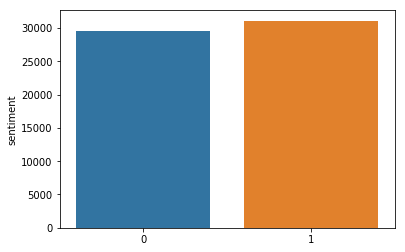

In [139]:
sns.barplot(x=[1,0],y=tweets.sentiment.value_counts(),data=tweets)

In [140]:
data_base=tweets.tweet.tolist()
total_words=[]                      # All words
for i in data_base:
    for j in i.split():
        j=j.lower()
        total_words.append(j)
print("Total words = ",len(total_words))

Total words =  1229164


In [141]:
w_c=pd.DataFrame(data=total_words,columns=["words"])
w_c.shape

(1229164, 1)

In [142]:
w_c_filtered=w_c[w_c["words"].map(w_c["words"].value_counts())>2]
w_c_filtered.shape

(1220805, 1)

In [143]:
w_c_filtered =pd.DataFrame(data= w_c_filtered["words"].unique() , columns=["words"])
w_c_filtered.shape

(8687, 1)

In [144]:
all_words=w_c_filtered.words.tolist()

In [145]:
flt_wrds = all_words

In [146]:
flt_wrd_set=set(flt_wrds)
wrd_chk = lambda x:1 if len((set(x.split()).intersection(flt_wrd_set)))>=1 else None

In [147]:
tweets["word_chk"]=tweets.tweet.apply(wrd_chk)

In [148]:
tweets.isnull().sum()

tweet                0
polarity             0
subjectivity         0
filtered_sentence    0
sentiment            0
word_chk             0
dtype: int64

In [149]:
tweets.dropna(inplace=True)

In [150]:
tweets.shape

(60630, 6)

## Word count vector represent and model training - - - - - -

In [151]:
word_vector=[]
for i in tweets.tweet:
    i=i.lower()
    mat=[i.count(j) for j in flt_wrds]
    word_vector.append(mat)

In [152]:
X_count_vect = pd.DataFrame(word_vector,columns=flt_wrds)
X_count_vect.shape

(60630, 8687)

In [153]:
y=tweets.sentiment

In [154]:
X_train,X_test,y_train,y_test=train_test_split(X_count_vect,y,test_size=0.25,random_state=3)

In [155]:
def reports(ytrue,predicted):
    print("Accuracy : {}".format(metrics.accuracy_score(ytrue,predicted)))
    print("Precision : {}".format(metrics.precision_score(ytrue,predicted)))
    print("Recall : {}".format(metrics.recall_score(ytrue,predicted)))
    print("Logloss : {}".format(metrics.log_loss(ytrue,predicted)))
    print("F1 Score : {}".format(metrics.f1_score(ytrue,predicted)))
    print("AUC : {}".format(metrics.roc_auc_score(ytrue,predicted)))
    print("Confusion Matrix : \n{}".format(metrics.confusion_matrix(ytrue,predicted)))

In [156]:
def all_models_report():
    
    global X_train
    global y_train
    global X_test
    global y_test
    
                # Random Forest Model
    
    
    rfst=ensemble.RandomForestClassifier(n_estimators=10)
    rfst.fit(X_train,y_train)
    rfst_pred =rfst.predict(X_test)
    print("\n\nFor Random Forest\n")
    reports(y_test,rfst_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,rfst_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
    
                # Decision Tree Model
    
    dst = tree.DecisionTreeClassifier()
    dst.fit(X_train,y_train)
    dst_pred = dst.predict(X_test)
    print("\n\nFor Decision Tree\n")
    reports(y_test,dst_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,dst_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
                    # Logistic Regression Model
    
    lgs = linear_model.LogisticRegression()
    lgs.fit(X_train,y_train)
    lgr_pred=lgs.predict(X_test)
    print("\n\nFor Logistic Regression\n")
    reports(y_test,lgr_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
    
                # Multinomial Naive Bayes Model
    
    clf2= MultinomialNB()
    clf2.fit(X_train,y_train)
    y_pred_mnb=clf2.predict(X_test)
    print("\n\nFor Multinomial Naive Bayes : \n")
    reports(y_test,y_pred_mnb)
    
    fpr, tpr, thresholds = roc_curve(y_test,y_pred_mnb)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
      
                 #  Support Vector Machine Model
    
#    svc_clf= SVC()
#    svc_clf.fit(X_train,y_train)
#    y_pred_gnb=svc_clf.predict(X_test)
#    print("\n\nFor Support Vector Machine Bayes : \n")
#    reports(y_test,y_pred_gnb)
    
#    fpr, tpr, thresholds = roc_curve(y_test,y_pred_gnb)
#    plt.plot([0, 1], [0, 1], linestyle='--')
#    plt.plot(fpr, tpr, marker='.')
#    plt.suptitle('AUC-ROC Curve', fontsize=20)
#    plt.xlabel('False positive Rate')
#    plt.ylabel('True Positive Rate')
#    plt.show()



For Random Forest

Accuracy : 0.8175880723050535
Precision : 0.8198725451944336
Recall : 0.8204060385216033
Logloss : 6.3003578423518185
F1 Score : 0.8201392050998504
AUC : 0.8175484835369591
Confusion Matrix : 
[[6089 1385]
 [1380 6304]]


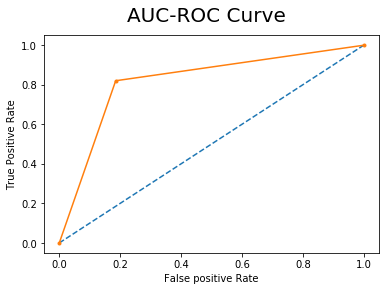



For Decision Tree

Accuracy : 0.867528697717377
Precision : 0.8724409448818897
Recall : 0.8651743883394065
Logloss : 4.575447962111282
F1 Score : 0.8687924725561944
AUC : 0.8675617727086382
Confusion Matrix : 
[[6502  972]
 [1036 6648]]


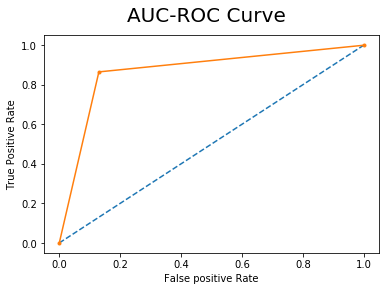

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




For Logistic Regression

Accuracy : 0.9440559440559441
Precision : 0.9441268191268192
Recall : 0.9456012493492972
Logloss : 1.9322619217429249
F1 Score : 0.9448634590377113
AUC : 0.9440342345221199
Confusion Matrix : 
[[7044  430]
 [ 418 7266]]


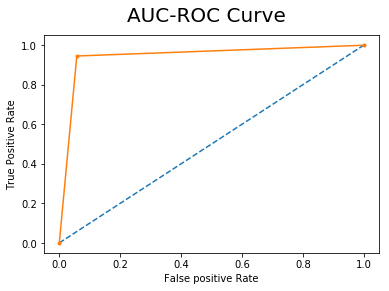



For Multinomial Naive Bayes : 

Accuracy : 0.8264282886924397
Precision : 0.8204185161699429
Recall : 0.8418792295679334
Logloss : 5.9950292205417055
F1 Score : 0.8310103410623675
AUC : 0.826211223025872
Confusion Matrix : 
[[6058 1416]
 [1215 6469]]


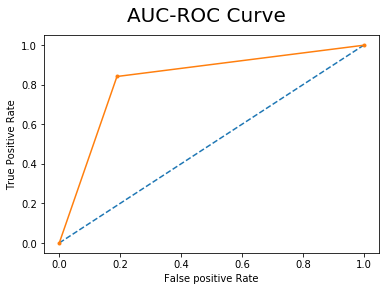

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
all_models_report()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)




For Logistic Regression : Solver - Lbfgs

Accuracy : 0.9558962264150943
Precision : 0.9509832697387731
Recall : 0.9399477806788512
Logloss : 1.5233061208098402
F1 Score : 0.9454333236066531
AUC : 0.9533833876571288
Confusion Matrix : 
[[4866  167]
 [ 207 3240]]


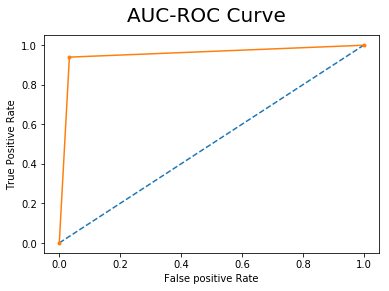

In [43]:
lgs = linear_model.LogisticRegression(solver="lbfgs")

lgs.fit(X_train,y_train)
lgr_pred=lgs.predict(X_test)
print("\n\nFor Logistic Regression : Solver - Lbfgs\n")
reports(y_test,lgr_pred)

fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.suptitle('AUC-ROC Curve', fontsize=20)
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.show()




For Logistic Regression : Solver - Liblinear

Accuracy : 0.9620283018867924
Precision : 0.9570049722140976
Recall : 0.9492312155497534
Logloss : 1.3115098514131467
F1 Score : 0.9531022429362075
AUC : 0.9600119916413579
Confusion Matrix : 
[[4886  147]
 [ 175 3272]]


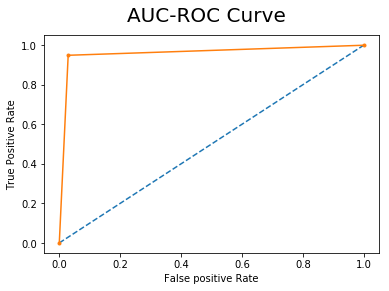

In [44]:
lgs = linear_model.LogisticRegression(solver="liblinear")

lgs.fit(X_train,y_train)
lgr_pred=lgs.predict(X_test)
print("\n\nFor Logistic Regression : Solver - Liblinear\n")
reports(y_test,lgr_pred)

fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.suptitle('AUC-ROC Curve', fontsize=20)
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)




For Logistic Regression : Solver - Saga

Accuracy : 0.9511792452830189
Precision : 0.9443305010254908
Recall : 0.9350159559036844
Logloss : 1.6862270461090525
F1 Score : 0.9396501457725948
AUC : 0.9486325557384506
Confusion Matrix : 
[[4843  190]
 [ 224 3223]]


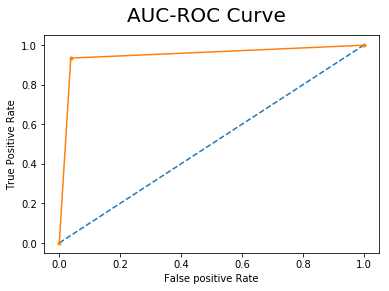

In [45]:
lgs = linear_model.LogisticRegression(solver="saga",penalty="l1")

lgs.fit(X_train,y_train)
lgr_pred=lgs.predict(X_test)
print("\n\nFor Logistic Regression : Solver - Saga\n")
reports(y_test,lgr_pred)

fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.suptitle('AUC-ROC Curve', fontsize=20)
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



For Logistic Regression : Solver - Newton-CG

Accuracy : 0.9620283018867924
Precision : 0.9570049722140976
Recall : 0.9492312155497534
Logloss : 1.3115098514131467
F1 Score : 0.9531022429362075
AUC : 0.9600119916413579
Confusion Matrix : 
[[4886  147]
 [ 175 3272]]


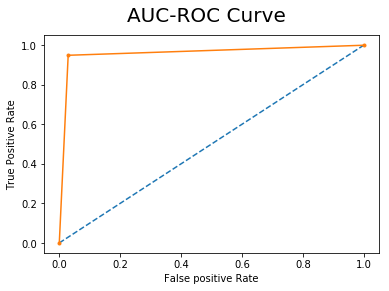

In [46]:
lgs = linear_model.LogisticRegression(solver="newton-cg",penalty="l2")

lgs.fit(X_train,y_train)
lgr_pred=lgs.predict(X_test)
print("\n\nFor Logistic Regression : Solver - Newton-CG\n")
reports(y_test,lgr_pred)

fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.suptitle('AUC-ROC Curve', fontsize=20)
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [47]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])



# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])


emoticons = emoticons_happy.union(emoticons_sad)


special_char=re.compile(r'[-%<>.?!,;#:/\\()^~`$₹+\'*&_{}=|0-9]')  # All special characters

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\u200b"
        "\n"
        "❌▶◾✔️➕➖•❤•●⭐🤝✌🤟🤩🤪🤣🤗"         "]+", flags=re.UNICODE)


#stop_words = set(stopwords.words('english'))
corp=words.words()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def clean_text(tweet):    
    tweet = tweet.lower()
    #global stop_words
    global emoticons
    global emoji_pattern
    global special_char
    global corp
    lemmatizer = WordNetLemmatizer() 

    #tweet = re.sub('@.*? |#.*? |@.*?: |#.*?: |@.*?:|#.*?:', '', tweet)
    tweet = re.sub('@.*? |@.*?:', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = re.sub(r'https?:\/\/.*|http?:\/\/.*',"",tweet)
    tweet =re.sub("b\"RT|b\'|b\"|b\'RT|b\'rt|b\"rt|\\n|\\\\n|RT", '', tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    tweet = special_char.sub(r" ",tweet)
    
    word_tokens = word_tokenize(tweet)

    filtered_tweet = []
    for w in word_tokens:
        if ((w in corp)  and (w not in emoticons) and (w not in string.punctuation)  and (len(w)>1)):
            filtered_tweet.append(w)
            
    
    filtered_tweets=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_tweet]        
    filtered_sentence = ' '.join(filtered_tweets)
    return filtered_sentence

In [48]:
def pred_text(text):
    global lgs
    global flt_wrds
    text = clean_text(text)
    i=text.lower()
    mat=[i.count(j) for j in flt_wrds]
    lgr_pred=lgs.predict([mat])
    
    
    if(lgr_pred==1):
        print("Logistic Regression Prediction : POSITIVE")
        
    else:
        print("Logistic Regression Prediction : NEGATIVE")

In [49]:
pred_text("Hi i am a good boy.")

Logistic Regression Prediction : POSITIVE


In [50]:
pred_text("Rohit is so dumb")

Logistic Regression Prediction : NEGATIVE


In [51]:
pred_text("Pubg lite has poor graphics quality")

Logistic Regression Prediction : NEGATIVE


In [52]:
pred_text("This project is very interesting. but very time consuming. code is very long")

Logistic Regression Prediction : NEGATIVE


In [53]:
pred_text("This project is very interesting.")

Logistic Regression Prediction : POSITIVE


In [97]:
pred_text("i hope one day this pandemic situation will be over")

Logistic Regression Prediction : POSITIVE


In [59]:
pred_text("Feeling depressed on this pandemic situation.")

Logistic Regression Prediction : NEGATIVE


In [66]:
pred_text("in this lockdown period i have learned so many new things")

Logistic Regression Prediction : POSITIVE


In [85]:
pred_text("in this quarantine period, our environment is curing.")

Logistic Regression Prediction : POSITIVE


In [95]:
pred_text("i am mentally disturbed during the quarantine")

Logistic Regression Prediction : NEGATIVE


In [99]:
pred_text("India is fighting the pandemic situation greatly.")

Logistic Regression Prediction : POSITIVE


In [74]:
pred_text("Rainy season is best for the plants")

Logistic Regression Prediction : POSITIVE


In [83]:
pred_text("The boy is smart")

Logistic Regression Prediction : POSITIVE
